# NFL Draft Success Analysis

In this notebook we analyze NFL data regarding team draft performance and team success in the following years. Three data sets are used for this project:

1. NFL Team Draft Data (who each team drafted which year)
2. NFL Player Performance Data (how each player performed each year in the NFL)
3. NFL Team Performance Data (how each team performed each year)

## Import

In [55]:
#Import Packages
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.cluster import Birch
from sklearn.cluster import KMeans

In [202]:
#Import files
ddf = pd.read_excel('team_draft_data.xlsx')
pdf = pd.read_excel('player_data.xlsx', sheet_name='final')
tpf = pd.read_excel('team_historical_records.xlsx')

## Analysis Description

In order to perform analysis on the data set, for each NFL draft class we need to sum the approximate value (AV) for each player over the first five years of their career. Then we do a sum for all the players for a single team as long as they were with that team. Therefore, players who were traded within that time frame will not add AV to the team after they have been traded. This will produce a cumulative 5 year team AV score for each team for each draft year.

The team AV score will then be compared to the team records for those years to observe trends in team draft performance and team performance. 

### Clean the dataframes: Player Yearly AV Data

In [203]:
#Remove the career totals
pdf = pdf[pdf.year != 'Career']
pdf

,year,age,team,av,name
0,2012,23,ARI,-5.0,Ryan Lindley
2,2 yrs,2 yrs,ARI,-4.0,Ryan Lindley
3,2009,26,CLE,-4.0,Derek Anderson
4,1998,26,PHI,-3.0,Bobby Hoying
6,2012,24,ARI,-2.0,John Skelton
...,...,...,...,...,...
50056,NaN,NaN,MIA,NaN,Austin Reiter
50057,NaN,NaN,NOR,NaN,Austin Reiter
50058,1 yr,1 yr,MIA,NaN,Austin Reiter
50059,1 yr,1 yr,NOR,NaN,Austin Reiter


In [204]:
#Remove total values for a team (values containing 'yr' or 'yrs') and just leave the year values 
pdf = pdf[(~pdf.year.str.contains('yrs', na=False)) & (~pdf.year.str.contains('yr', na=False))]
pdf

,year,age,team,av,name
0,2012,23,ARI,-5.0,Ryan Lindley
3,2009,26,CLE,-4.0,Derek Anderson
4,1998,26,PHI,-3.0,Bobby Hoying
6,2012,24,ARI,-2.0,John Skelton
7,2009,28,STL,-2.0,Kyle Boller
...,...,...,...,...,...
50054,2021,30,WAS,NaN,Brandon Scherff
50055,2021,30,2TM,NaN,Austin Reiter
50056,NaN,NaN,MIA,NaN,Austin Reiter
50057,NaN,NaN,NOR,NaN,Austin Reiter


In [205]:
#Check for null years
pdf.year.isnull().sum()

1551

In [207]:
#Remove null years
pdf = pdf[pdf.year.notna()]
pdf.year.isnull().sum()

0

In [208]:
#Remove any wierd characters in the year column (* and +)
pdf = pdf.replace(to_replace=r'\*', value='', regex=True)
pdf = pdf.replace(to_replace=r'\+' , value='', regex=True)
pdf[pdf.name == 'Budda Baker']

,year,age,team,av,name
85,2021,25,ARI,0.0,Budda Baker
30080,2018,22,ARI,5.0,Budda Baker
32879,2019,23,ARI,6.0,Budda Baker
40353,2017,21,ARI,9.0,Budda Baker
44268,2020,24,ARI,14.0,Budda Baker


In [209]:
#Convert year, age, and av to numeric values

for column in pdf.columns:
    if column == 'year' or column == 'age' or column == 'av':
        pdf[column] = pd.to_numeric(pdf[column])

<AxesSubplot:>

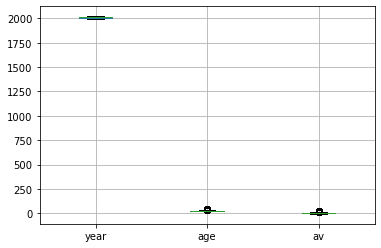

In [210]:
pdf.boxplot()

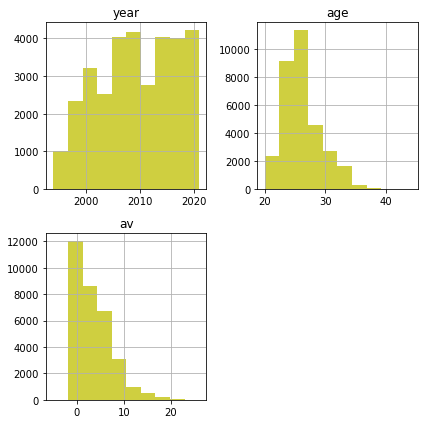

In [211]:
#Histogram of numerical values
pdf.hist(figsize=(6, 6), bins=10, alpha = 0.75, color = 'y')
plt.tight_layout()
plt.show()